## Designing Gradebook for a Fictional Class
### Inspired by the functions of Gradescope

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import os

In [5]:
from project import *

## About the Project

The file contains the gradebook from a fictional course with 535 students. 

In this project, we will:
1. Clean and process the data to compute total course grades according to a fictional syllabus (below).
2. Qualitatively understand how students did in the course.
3. Understand how student grades vary with small changes in performance on each assignment.

---

### The Syllabus

The course syllabus for this fictional class is as follows:

* **Lab assignments (20% total)**
    - Each lab is worth the same amount, regardless of each lab's raw point total.
    - The lowest lab is dropped.
    - Each lab may be revised for up to (and including) one week after the deadline for a 10% penalty, for up to (and including) two weeks after the deadline for a 30% penalty, and beyond that for a 60% penalty. Such revisions are reflected in the `'Lateness'` columns in the gradebook.
* **Projects (30% total)** 
    - Each project consists of an autograded portion, and **possibly** a free response portion.
    - The total points for a single project consist of the sum of the raw score of the two portions.
    - Each project is worth the same amount, regardless of each project's raw point total.
* **Checkpoints (2.5% total)**
    - Each project checkpoint is worth the same amount, regardless of each project checkpoint's raw point total.
* **Discussions (2.5% total)**
    - Each discussion is worth the same amount, regardless of each discussion's raw point total.
* **Midterm Exam (15%)**
* **Final Exam (30%)**

Run the cell below to load in the aforementioned `grades` dataset.

In [48]:
grades_fp = os.path.join('data', 'grades.csv')
grades = pd.read_csv(grades_fp)
grades.head()

,PID,College,Level,lab01,lab01 - Max Points,lab01 - Lateness (H:M:S),lab02,lab02 - Max Points,lab02 - Lateness (H:M:S),project01,...,discussion07 - Lateness (H:M:S),discussion08,discussion08 - Max Points,discussion08 - Lateness (H:M:S),discussion09,discussion09 - Max Points,discussion09 - Lateness (H:M:S),discussion10,discussion10 - Max Points,discussion10 - Lateness (H:M:S)
0,A14721419,SI,JR,99.735279,100.0,00:00:00,84.990171,100.0,00:00:00,75.282632,...,00:00:00,8.895294,10,00:00:00,10.000000,10,780:01:28,10.000000,10,00:00:00
1,A14883274,TH,JR,98.829476,100.0,00:00:00,50.784231,100.0,00:00:00,52.929482,...,669:12:21,9.022407,10,00:00:00,9.020283,10,00:00:00,9.437368,10,00:00:00
2,A14164800,SI,SR,86.513369,100.0,00:00:00,47.802820,100.0,00:00:00,46.122801,...,00:00:00,3.030538,10,00:04:51,7.613698,10,00:00:00,9.624617,10,00:00:00
3,A14847419,TH,JR,100.000000,100.0,00:00:00,100.000000,100.0,00:00:00,79.121806,...,00:00:00,10.000000,10,00:00:00,9.249126,10,00:00:00,10.000000,10,00:00:00
4,A14162943,SI,JR,66.506974,100.0,00:00:00,33.422412,100.0,00:00:00,41.823703,...,00:00:00,4.439606,10,00:00:00,4.485291,10,00:00:00,6.282712,10,00:00:00


<a name='part1'></a>

## Part 1: Enumerating the Assignments 🔢

The implementation of the function `get_assignment_names`, which takes in a DataFrame like `grades` and returns a dictionary with the following structure:
- The keys are the general areas of [the syllabus](#The-Syllabus): `'lab'`, `'project'`, `'midterm'`, `'final'`, `'disc'`, and `'checkpoint'`.
- The values are **lists** that contain all the assignment names of that type. For example, the lab assignments all have names of the form `'labXX'` where `XX` is a zero-padded two digit number. If the class has 5 labs, the returned dictionary's value for the `'lab'` key should be `['lab01', 'lab02', 'lab03', 'lab04', 'lab05']`.

In [ ]:
def get_assignment_names(grades):
    '''
    get_assignment_names takes in a dataframe like grades and returns 
    a dictionary with the following structure:
    The keys are the general areas of the syllabus: lab, project, 
    midterm, final, disc, checkpoint
    The values are lists that contain the assignment names of that type. 
    For example the lab assignments all have names of the form labXX where XX 
    is a zero-padded two digit number. See the doctests for more details.    
    :Example:
    >>> grades_fp = os.path.join('data', 'grades.csv')
    >>> grades = pd.read_csv(grades_fp)
    >>> names = get_assignment_names(grades)
    >>> set(names.keys()) == {'lab', 'project', 'midterm', 'final', 'disc', 'checkpoint'}
    True
    >>> names['final'] == ['Final']
    True
    >>> 'project02' in names['project']
    True
    '''
    syllabus_col = [x for x in grades.columns if not ("Lateness" in x or "Max" in x or "response" in x)]
    labs_col = [x for x in syllabus_col if "lab" in x]
    disc_col = [x for x in syllabus_col if "discussion" in x]
    project_col = [x for x in syllabus_col if "project" in x and not "checkpoint" in x]
    checkpoint_col = [x for x in syllabus_col if "project" in x and "checkpoint" in x]
    midterm_col = [x for x in syllabus_col if "Midterm" in x]
    final_col = [x for x in syllabus_col if "Final" in x]
    syllabus_dict = {"lab": labs_col, "project": project_col, "midterm": midterm_col, "final": final_col, "disc": disc_col, "checkpoint": checkpoint_col}
    return syllabus_dict

<a name='part2'></a>

## Part 2: Computing Project Grades 🧮

Compute each student's overall grade on the first type of assignment – projects.

In [130]:
def projects_total(grades):
    '''
    projects_total takes in a DataFrame grades and returns the total project grade
    for the quarter according to the syllabus. 
    The output Series should contain values between 0 and 1.
    
    :Example:
    >>> grades_fp = os.path.join('data', 'grades.csv')
    >>> grades = pd.read_csv(grades_fp)
    >>> out = projects_total(grades)
    >>> np.all((0 <= out) & (out <= 1))
    True
    >>> 0.7 < out.mean() < 0.9
    True
    '''
    project_col = get_assignment_names(grades)["project"]
    result_df = pd.DataFrame()
    for project in project_col:
        fr = project + "_free_response"
        fr_score = 0
        fr_max = 0
        if fr in grades.columns:
            fr_score = grades[fr].fillna(0).astype(float)
            fr_max = grades[fr + " - Max Points"]
        raw = grades[project].fillna(0).astype(float) + fr_score
        total = grades[project + " - Max Points"] + fr_max
        result_df[project] = raw/total
    result = np.mean(result_df, axis=1)
    return result

[0.9272361171611084,
 0.7555839230433951,
 0.6640895441613449,
 0.9609710530238391,
 0.7236894006128984,
 0.9054098887673023,
 0.8180047086312013,
 0.9523949679244126,
 0.8851707416288722,
 0.9511252627114187,
 0.9240668211248633,
 0.7010134954417957,
 0.9640828669449067,
 0.9604763995782599,
 0.8009785193753152,
 0.8923730942278745,
 0.9959837560706563,
 0.5763087202535503,
 0.9720244189381327,
 0.9044792538532883,
 0.9116396740314924,
 0.8536678732102638,
 0.8759731185476773,
 0.9654283295235432,
 0.901270085895249,
 0.8733881255676067,
 0.874760914292658,
 0.8749929539039863,
 0.8574625890052889,
 0.7237880983895727,
 0.9255606220360058,
 0.9662561578987425,
 0.9496974811541252,
 0.8770844451677782,
 0.9648581801726925,
 0.9521534027181145,
 0.9271909956730682,
 0.81248314182159,
 0.8273945555170723,
 0.9389645468361817,
 0.7431096965336522,
 0.8990936952909954,
 0.8925806629832322,
 0.9688669806933303,
 0.918183111689201,
 0.9638580502197522,
 0.737369727336554,
 0.8028416375596787

<a name='part3'></a>

## Part 3: Computing Lab Grades 🧪

Clean and process the lab grades, which involves a bit more work than was necessary for projects. To do this, you will develop functions that:
- identify late submissions
- compute normalized scores for each lab assignment, factoring in late penalties
- drop the lowest lab grade and compute a total lab score for each student

In [ ]:
def last_minute_submissions(grades):
    """
    last_minute_submissions takes in a DataFrame 
    grades and returns a Series indexed by lab assignment that 
    contains the number of submissions that were turned 
    in on time by students that were marked "late" by Gradescope.
    :Example:
    >>> fp = os.path.join('data', 'grades.csv')
    >>> grades = pd.read_csv(fp)
    >>> out = last_minute_submissions(grades)
    >>> isinstance(out, pd.Series)
    True
    >>> np.all(out.index == ['lab0%d' % d for d in range(1, 10)])
    True
    >>> (out > 0).sum()
    8
    """
    
    lab_col = get_assignment_names(grades)["lab"] #this will also be the index of the series
    lab_late = [lab + " - Lateness (H:M:S)" for lab in lab_col]
    hour_threshold = 8
    last_minute_count = []
    lab_late_df = grades[lab_late]
    for lab in lab_late:
        lab_df = lab_late_df[[lab]][lab_late_df[lab] != "00:00:00"]
        lab_df[lab] = lab_df[lab].str.split(":")
        last_minute_count.append(sum(lab_df[lab].str[0].astype(int) < hour_threshold))
    return pd.Series(last_minute_count, index=lab_col)

In [ ]:
def lateness_penalty(col):
    """
    adjust_lateness takes in a Series containing
    how late a submission was processed
    and returns a Series of penalties according to the
    syllabus.
    :Example:
    >>> fp = os.path.join('data', 'grades.csv')
    >>> col = pd.read_csv(fp)['lab01 - Lateness (H:M:S)']
    >>> out = lateness_penalty(col)
    >>> isinstance(out, pd.Series)
    True
    >>> set(out.unique()) <= {1.0, 0.9, 0.7, 0.4}
    True
    """
    on_time_df = pd.DataFrame(col)
    late_hour_threshold = 8
    one_week = 24*7 + 1
    two_week = 24*7*2 + 1

    on_time_df = on_time_df.assign(
        hour = col.str.split(":").str[0].astype(int), 
        mins = col.str.split(":").str[1].astype(int), 
        sec = col.str.split(":").str[2].astype(int), 
    )

    on_time_df = on_time_df.assign(
        penalty = np.where(on_time_df["hour"] < late_hour_threshold, 1.0, np.where(on_time_df["hour"] < one_week, 0.9, np.where(on_time_df["hour"] < two_week, 0.7, 0.4))) 
    )
    return on_time_df["penalty"]

In [ ]:
def process_labs(grades):
    """
    process_labs takes in a DataFrame like grades and returns
    a DataFrame of processed lab scores. The output should:
      * have the same index as `grades`,
      * have one column for each lab assignment (e.g. `'lab01'`, `'lab02'`,..., `'lab09'`),
      * have values representing the final score for each lab assignment, 
        adjusted for lateness and scaled to a score between 0 and 1.
    :Example:
    >>> fp = os.path.join('data', 'grades.csv')
    >>> grades = pd.read_csv(fp)
    >>> out = process_labs(grades)
    >>> out.columns.tolist() == ['lab%02d' % x for x in range(1, 10)]
    True
    >>> np.all((0.65 <= out.mean()) & (out.mean() <= 0.90))
    True
    """
    lab_col = get_assignment_names(grades)["lab"]
    grade_copy = grades.copy()
    result = pd.DataFrame()
    for lab in lab_col:
        late = lab + " - Lateness (H:M:S)"
        max_point = lab + " - Max Points"
        final_grade = (grade_copy[lab]*lateness_penalty(grade_copy[late])/grade_copy[max_point]).to_numpy()
        result[lab] = final_grade
    return result


The implementation of the function `lab_total`, which takes in a DataFrame of processed assignments and returns a Series containing the total lab grade for each student according to [the syllabus](#The-Syllabus). Your answers should be proportions between 0 and 1. 

In [ ]:
def lab_total(processed):
    """
    lab_total takes in DataFrame of processed assignments (like the output of 
    Question 5) and returns a Series containing the total lab grade for each 
    student according to the syllabus.
    
    Your answers should be proportions between 0 and 1.
    :Example:
    >>> cols = 'lab01 lab02 lab03'.split()
    >>> processed = pd.DataFrame([[0.2, 0.90, 1.0]], index=[0], columns=cols)
    >>> np.isclose(lab_total(processed), 0.95).all()
    True
    """
    grade_copy = processed.copy()
    grade_copy = grade_copy.fillna(0)
    return pd.Series(np.mean(np.sort(grade_copy.values, axis=1)[:, 1::], axis=1))

<a name='part4'></a>

## Part 4: Putting It All Together 🧩

It's time to compute the letter grade of each student.

In [ ]:
def total_points(grades):
    """
    total_points takes in a DataFrame grades and returns a Series
    containing each student's course grade.
    Course grades should be proportions between 0 and 1.
    :Example:
    >>> fp = os.path.join('data', 'grades.csv')
    >>> grades = pd.read_csv(fp)
    >>> out = total_points(grades)
    >>> np.all((0 <= out) & (out <= 1))
    True
    >>> 0.7 < out.mean() < 0.9
    True
    """
    lab_result = lab_total(process_labs(grades))
    project_result = projects_total(grades)

    final = get_assignment_names(grades)["final"]
    final_df = pd.DataFrame()
    for f in final:
        max_point = f + " - Max Points"
        final_df[f] = grades[f].fillna(0)/grades[max_point]
    final_result = np.mean(final_df, axis=1)

    mt = get_assignment_names(grades)["midterm"]
    mt_df = pd.DataFrame()
    for m in mt:
        max_point = m + " - Max Points"
        mt_df[m] = grades[m].fillna(0)/grades[max_point]
    mt_result = np.mean(mt_df, axis=1)

    disc = get_assignment_names(grades)["disc"]
    disc_df = pd.DataFrame()
    for d in disc:
        max_point = d + " - Max Points"
        disc_df[d] = grades[d].fillna(0)/grades[max_point]
    disc_result = np.mean(disc_df, axis=1)

    checkpoint = get_assignment_names(grades)["checkpoint"]
    cp_df = pd.DataFrame()
    for cp in checkpoint:
        max_point = cp + " - Max Points"
        cp_df[cp] = grades[cp].fillna(0)/grades[max_point]
    cp_result = np.mean(cp_df, axis=1)

    course_grade = cp_result*0.025 + disc_result*0.025 + lab_result*0.2 + project_result*0.3 + mt_result*0.15 + final_result*0.3
    return course_grade

#### `final_grades`

Complete the implementation of the function `final_grades`, which takes in final course grades (as computed in Question 7) and returns a Series of letter grades as determined by the standard cutoffs (without pluses or minuses):

| Letter Grade | Cutoff |
|:--- | --- |
| A | grade >= 0.9 |
| B | 0.8 <= grade < 0.9 |
| C | 0.7 <= grade < 0.8 |
| D | 0.6 <= grade < 0.7 |
| F | grade < 0.6 |

***Note:*** Do not round anyone's course grade when determining their letter grade.

#### `letter_proportions`

Complete the implementation of the function `letter_proportions`, which takes in a DataFrame `grades` and returns a Series containing the proportion of the class that received each letter grade. For instance, this Series might tell us that the proportion of the class receiving Bs was 0.45, As was 0.33, Cs was 0.16, Ds was 0.05, and Fs was 0.01 (though these are made up numbers). The index of this Series should be letters, and the **values should be sorted in decreasing order**.

In [194]:
final_grades(total_points(grades)).value_counts(normalize=True)

B    0.506542
C    0.224299
A    0.207477
D    0.031776
F    0.029907
dtype: float64

In [ ]:
def final_grades(total):
    """
    final_grades takes in the final course grades
    as above and returns a Series of letter grades
    given by the standard cutoffs.
    :Example:
    >>> out = final_grades(pd.Series([0.92, 0.81, 0.41]))
    >>> np.all(out == ['A', 'B', 'F'])
    True
    """
    return pd.Series(np.where(total >= 0.9, "A", 
    np.where((total >= 0.8) & (total < 0.9), "B", 
    np.where((total >= 0.7) & (total < 0.8), "C", 
    np.where((total >= 0.6) & (total < 0.7), "D", "F")))))


def letter_proportions(grades):
    """
    letter_proportions takes in the dataframe grades 
    and outputs a Series that contains the proportion
    of the class that received each grade.
    :Example:
    >>> fp = os.path.join('data', 'grades.csv')
    >>> grades = pd.read_csv(fp)
    >>> out = letter_proportions(grades)
    >>> np.all(out.index == ['B', 'C', 'A', 'D', 'F'])
    True
    >>> out.sum() == 1.0
    True
    """
    return final_grades(total_points(grades)).value_counts(normalize=True)

<a name='part5'></a>

## Part 5: Do Seniors Get Worse Grades? 👵

### Question 9

You notice that students who are seniors on average did worse in the class (if you can't verify this, you should go back and check your work!). Is this difference significant, or just due to noise?

Perform a hypothesis test, assessing the likelihood of the above statement under the null hypothesis: 
> Seniors earn grades that are roughly equal on average to the rest of the class.

To do this, complete the implementation of the function `simulate_pval`, which takes in a DataFrame `grades` and a number of simulations `N` and returns the **probability that the mean grade (between 0 and 1) earned by a random subset of students* is less than or equal to the average grade of seniors** (i.e. calculate and return the p-value).

*_The size of each random subset must be same the number of seniors in the class._

In [214]:
df = pd.DataFrame()
df['Level'] = grades['Level']
df['Score'] = total_points(grades)
obs = df.groupby("Level")['Score'].mean().loc["SR"]
sr_size = df["Level"].value_counts().loc["SR"]
test_stats = []
for _ in np.arange(100000):
    sim = df.sample(sr_size)
    test_stat = sim["Score"].mean()
    test_stats.append(test_stat)

np.mean(test_stats <= obs)

0.00028

In [205]:
df.sample(sr_size)["Score"].mean()

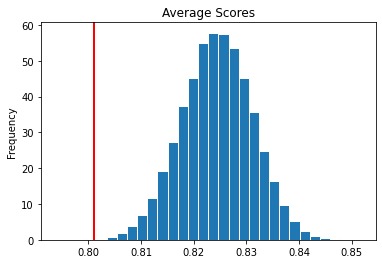

In [219]:
import matplotlib.pyplot as plt
pd.Series(test_stats).plot(kind='hist', 
                         density=True,
                         bins=30,
                         ec='w',
                         title='Average Scores');
plt.axvline(x=obs, color='red', linewidth=2);

In [ ]:
def simulate_pval(grades, N):
    """
    simulate_pval takes in a DataFrame grades and
    a number of simulations N and returns the p-value
    for the hypothesis test described in the notebook.
    :Example:
    >>> fp = os.path.join('data', 'grades.csv')
    >>> grades = pd.read_csv(fp)
    >>> out = simulate_pval(grades, 1000)
    >>> 0 <= out <= 0.1
    True
    """
    df = pd.DataFrame()
    df['Level'] = grades['Level']
    df['Score'] = total_points(grades)
    obs = df.groupby("Level")['Score'].mean().loc["SR"]
    sr_size = df["Level"].value_counts().loc["SR"]
    test_stats = []
    for _ in np.arange(N):
        sim = df.sample(sr_size)
        test_stat = sim["Score"].mean()
        test_stats.append(test_stat)

    return np.mean(test_stats <= obs)

<a name='part6'></a>

## Part 6: What is the True Distribution of Grades? 🧐

The gradebook for this class only reflects one particular instance of each student's performance, subject to the effects of all the little events and hiccups that occurred throughout the quarter. Would you have done better on the midterm if your roommate didn't kept you up all night with their coughing? Wasn't it lucky that the example you were studying just before the final happened to appear on the exam?

In [259]:
result_df = pd.DataFrame()
for project in project_col:
    fr = project + "_free_response"
    fr_score = 0
    fr_max = 0
    if fr in grades.columns:
        fr_score = grades[fr].fillna(0).astype(float)
        fr_max = grades[fr + " - Max Points"]
    raw = grades[project].fillna(0).astype(float) + fr_score
    total = grades[project + " - Max Points"] + fr_max
    result_df[project] = raw/total
project_result = np.mean(result_df, axis=1)
result_df

,project01,project02,project03,project04,project05
0,0.902826,0.949554,0.855196,0.909746,0.963848
1,0.629166,0.879261,0.882010,0.665124,0.774100
2,0.611228,0.872909,0.770437,0.553977,0.597845
3,0.924086,0.955583,0.942994,0.990239,1.000000
4,0.568237,0.960433,0.908058,0.593124,0.657378
...,...,...,...,...,...
530,0.926306,0.909326,0.980707,0.959160,0.971672
531,0.756583,0.956447,0.763842,0.911254,0.945849
532,0.812733,0.967382,0.901077,0.776096,0.852963
533,0.767939,0.920880,0.887178,0.682945,0.808400


In [249]:
def total_points_with_noise(grades):
    """
    total_points_with_noise takes in a dataframe like grades, 
    adds noise to the assignments as described in notebook, and returns
    the total scores of each student calculated with noisy grades.
    :Example:
    >>> fp = os.path.join('data', 'grades.csv')
    >>> grades = pd.read_csv(fp)
    >>> out = total_points_with_noise(grades)
    >>> np.all((0 <= out) & (out <= 1))
    True
    >>> 0.7 < out.mean() < 0.9
    True
    """
    def add_noise(df):
        return (df + np.random.normal(0, 0.02, size=(df.shape[0], df.shape[1]))).clip(0, 1)
    #lab
    lab_noise = add_noise(process_labs(grades))
    lab_result = lab_total(lab_noise)

    #project
    result_df = pd.DataFrame()
    project_col = get_assignment_names(grades)["project"]
    for project in project_col:
        fr = project + "_free_response"
        fr_score = 0
        fr_max = 0
        if fr in grades.columns:
            fr_score = grades[fr].fillna(0).astype(float)
            fr_max = grades[fr + " - Max Points"]
        raw = grades[project].fillna(0).astype(float) + fr_score
        total = grades[project + " - Max Points"] + fr_max
        result_df[project] = raw/total
    result_df = add_noise(result_df)
    project_result = np.mean(result_df, axis=1)

    #checkpoint
    checkpoint = get_assignment_names(grades)["checkpoint"]
    cp_df = pd.DataFrame()
    for cp in checkpoint:
        max_point = cp + " - Max Points"
        cp_df[cp] = grades[cp].fillna(0)/grades[max_point]
    cp_df = add_noise(cp_df)
    cp_result = np.mean(cp_df, axis=1)

    #discussion
    disc = get_assignment_names(grades)["disc"]
    disc_df = pd.DataFrame()
    for d in disc:
        max_point = d + " - Max Points"
        disc_df[d] = grades[d].fillna(0)/grades[max_point]
    disc_df = add_noise(disc_df)
    disc_result = np.mean(disc_df, axis=1)


    #final
    final = get_assignment_names(grades)["final"]
    final_df = pd.DataFrame()
    for f in final:
        max_point = f + " - Max Points"
        final_df[f] = grades[f].fillna(0)/grades[max_point]
    final_df = add_noise(final_df)
    final_result = np.mean(final_df, axis=1)

    #midterm
    mt = get_assignment_names(grades)["midterm"]
    mt_df = pd.DataFrame()
    for m in mt:
        max_point = m + " - Max Points"
        mt_df[m] = grades[m].fillna(0)/grades[max_point]
    mt_df = add_noise(mt_df)
    mt_result = np.mean(mt_df, axis=1)

    course_grade = cp_result*0.025 + disc_result*0.025 + lab_result*0.2 + project_result*0.3 + mt_result*0.15 + final_result*0.3
    return course_grade

0      0.902465
1      0.816654
2      0.759665
3      0.908073
4      0.675083
         ...   
530    0.865660
531    0.764832
532    0.859648
533    0.866322
534    0.894719
Length: 535, dtype: float64

In [ ]:
def add_noise(df):
    return (df + np.random.normal(0, 0.02, size=(df.shape[0], df.shape[1]))).clip(0, 1)
#lab
lab_noise = add_noise(process_labs(grades))
lab_result = lab_total(lab_noise)

#project
result_df = pd.DataFrame()
for project in project_col:
    fr = project + "_free_response"
    fr_score = 0
    fr_max = 0
    if fr in grades.columns:
        fr_score = grades[fr].fillna(0).astype(float)
        fr_max = grades[fr + " - Max Points"]
    raw = grades[project].fillna(0).astype(float) + fr_score
    total = grades[project + " - Max Points"] + fr_max
    result_df[project] = raw/total
result_df = add_noise(result_df)
project_result = np.mean(result_df, axis=1)

#checkpoint
checkpoint = get_assignment_names(grades)["checkpoint"]
cp_df = pd.DataFrame()
for cp in checkpoint:
    max_point = cp + " - Max Points"
    cp_df[cp] = grades[cp].fillna(0)/grades[max_point]
cp_df = add_noise(cp_df)
cp_result = np.mean(cp_df, axis=1)

#discussion
disc = get_assignment_names(grades)["disc"]
disc_df = pd.DataFrame()
for d in disc:
    max_point = d + " - Max Points"
    disc_df[d] = grades[d].fillna(0)/grades[max_point]
disc_df = add_noise(disc_df)
disc_result = np.mean(disc_df, axis=1)


#final
final = get_assignment_names(grades)["final"]
final_df = pd.DataFrame()
for f in final:
    max_point = f + " - Max Points"
    final_df[f] = grades[f].fillna(0)/grades[max_point]
final_df = add_noise(final_df)
final_result = np.mean(final_df, axis=1)

#midterm
mt = get_assignment_names(grades)["midterm"]
mt_df = pd.DataFrame()
for m in mt:
    max_point = m + " - Max Points"
    mt_df[m] = grades[m].fillna(0)/grades[max_point]
mt_df = add_noise(mt_df)
mt_result = np.mean(mt_df, axis=1)

course_grade = cp_result*0.025 + disc_result*0.025 + lab_result*0.2 + project_result*0.3 + mt_result*0.15 + final_result*0.3
course_grade